<a href="https://colab.research.google.com/github/abdelrahmanAh/Image_caption_flicker8/blob/main/Image_caption_flicker8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
! pip install -q kaggle


In [5]:
!mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d adityajn105/flickr8k

 99% 1.02G/1.04G [00:06<00:00, 157MB/s]
100% 1.04G/1.04G [00:06<00:00, 161MB/s]


In [ ]:
!unzip /content/flickr8k.zip  -d /content/flickr8k

In [9]:
import torch
from torch import nn,optim
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from get_loader import get_loader
from model import CNNtoRNN
from tqdm import tqdm

In [10]:
transform=transforms.Compose([
    transforms.Resize((356,356)),
    transforms.RandomCrop((299,299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])
train_loader,dataset=get_loader(root_folder='flickr8k/Images',annotation_file='flickr8k/captions.txt'
                                ,transform=transform,num_workers=2)
torch.backends.cudnn.benchmark=True
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

load_model=False
save_model=False
train_CNN=False

embed_size=256
hidden_size=256
vocab_size=len(dataset.vocab)
num_layers=2
learning_rate=1e-3
num_epochs=4

#tensorboard
writer=SummaryWriter("runs/flicker")
step=0

model=CNNtoRNN(embed_size,hidden_size=hidden_size,vocab_size=vocab_size,num_layers=num_layers).to(device)
cirterion=nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi['<PAD>'])
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

# Only finetune the CNN
for name, param in model.encoder.inception.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = train_CNN




Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
file_name='new)model_loss_3136_2022-04-14.gz'
path=f'/content/drive/MyDrive/model_image_caption_fli/{file_name}'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [14]:
model.train()
for epoch in range(num_epochs):
  total_loss=0
  for idx,(imgs,captions) in tqdm(enumerate(train_loader),total=len(train_loader),leave=False):
        imgs=imgs.to(device)
        captions=captions.to(device)
        output=model(imgs,captions[:-1])#-1 becouse we wouldn't train EOS
        loss=cirterion(output.reshape(-1,output.shape[2]),captions.reshape(-1))#becouse
        #cirterion only take 2 dim (seq_len,N,vocabulary_size),(seq_len,n)
        writer.add_scalar('Train loss',loss.item(),global_step=step)
        step+=1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
  print(f"at epoch {epoch} loss: {total_loss/len(train_loader)}")

at epoch 0 loss: 1.7902461199892368


at epoch 1 loss: 1.7690468166185462


at epoch 2 loss: 1.7622327902571486


at epoch 3 loss: 1.7584199491696866


In [ ]:
# file_name='new)model_loss_3136_2022-04-17.gz'
# path=f'/content/drive/MyDrive/model_image_caption_fli/{file_name}'
# torch.save(model.state_dict(),path)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
def get_text(nums):
  # text_ls=[ for i in nums]
  txt=''
  for i in nums:
    txt+=" "+train_loader.dataset.vocab.itos[i.item()] 
  print(txt)

In [14]:
from matplotlib import pyplot as plt
from PIL import Image
def show_im_text(index,path="/content/flickr8k/Images/"):
  img_name=dataset.imgs[index]
  img_cap=dataset.captions[index]
  img=Image.open(path+img_name)
  plt.imshow(img)
  print(img_cap)
  return transform(img)
  

A brown and white dog is running through the snow .


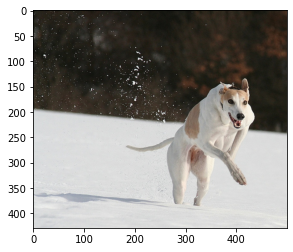

In [16]:
u=show_im_text(50)

In [17]:
u=u.unsqueeze(0).to(device)

In [18]:
model.eval()
model.caption_image(u,train_loader.dataset.vocab)

['<SOS>',
 'a',
 'white',
 'dog',
 'is',
 'running',
 'through',
 'the',
 'snow',
 '.',
 '<EOS>']

A child and a woman are at waters edge in a big city .


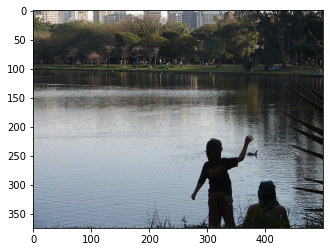

In [20]:
u=show_im_text(80)
u=u.unsqueeze(0).to(device)

In [21]:
model.eval()
model.caption_image(u,train_loader.dataset.vocab)

['<SOS>',
 'a',
 'man',
 'is',
 'standing',
 'on',
 'a',
 'rocky',
 'shore',
 'looking',
 'at',
 'the',
 'sunset',
 '.',
 '<EOS>']

In [22]:
#outside data sets test
def model_img(path):
  img=Image.open(path)
  plt.imshow(img)
  data_inputs=transform(img).unsqueeze(0).to(device)
  model.eval()
  print(model.caption_image(data_inputs,train_loader.dataset.vocab))

['<SOS>', 'a', 'man', 'in', 'a', 'white', 'shirt', 'and', 'jeans', 'is', 'jogging', 'on', 'a', 'track', '.', '<EOS>']


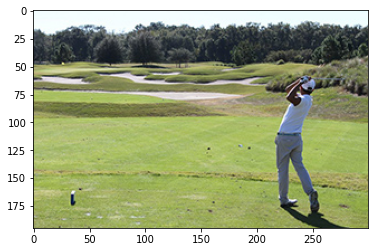

In [28]:
import requests
url='http://www.imgjuniorgolftour.com/_assets/themes/default/img/sports/junior-golf-tour/tournament-img-juniorgolftour.jpg'
img=requests.get(url,stream=True).raw
model_img(img)

In [36]:
import requests
url='https://image.shutterstock.com/image-photo/handsome-bearded-manager-entering-his-260nw-1478488796.jpg'
img=requests.get(url,stream=True).raw


['<SOS>', 'a', 'man', 'is', '<UNK>', 'a', 'product', 'at', 'a', 'restaurant', '.', '<EOS>']


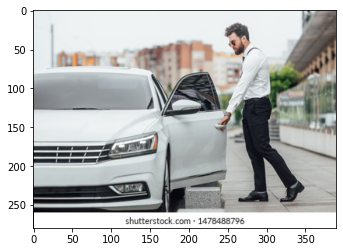

In [37]:
model_img(img)

['<SOS>', 'a', 'dog', 'is', 'running', 'through', 'a', 'field', 'of', 'grass', 'and', '<UNK>', '.', '<EOS>']


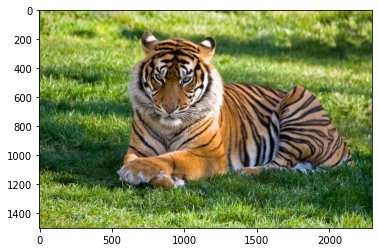

In [38]:
url='https://h5p.org/sites/default/files/h5p/content/1209180/images/file-6113d5f8845dc.jpeg'
img=requests.get(url,stream=True).raw
model_img(img)

['<SOS>', 'a', 'group', 'of', 'people', 'are', 'gathered', 'together', '.', '<EOS>']


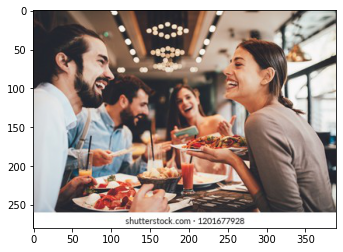

In [39]:
url='https://image.shutterstock.com/image-photo/group-happy-friends-having-breakfast-260nw-1201677928.jpg'
img=requests.get(url,stream=True).raw
model_img(img)